In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

2025-04-15 20:54:39.606816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744750479.795560      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744750479.850363      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_FOLDER = 'tusimple_processed/images'
MASK_FOLDER = 'tusimple_processed/masks'

In [3]:
def create_directories_if_not_exist(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print('Directory Created:', dir_path)
    else:
        print('Directory already exists:', dir_path)

In [4]:
create_directories_if_not_exist(IMAGE_FOLDER)
create_directories_if_not_exist(MASK_FOLDER)

Directory Created: tusimple_processed/images
Directory Created: tusimple_processed/masks


In [5]:
CLIPS_PATH = "/kaggle/input/tusimple/TUSimple/train_set/clips"


# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, '20.jpg')

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new filename based on last 2 directory names
        temp = frame_path[:-7].split('/')[-2:] # frame_path - /kaggle/input/tusimple/TUSimple/train_set/clips/0313-1/10000/20.jpg
        new_filename = f"{temp[0]}_{temp[1]}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, new_file_path)

Processing Clip: 0531
Processing Clip: 0601
Processing Clip: 0313-2
Processing Clip: 0313-1


In [6]:
print('Total Images in Dataset:', len(os.listdir(IMAGE_FOLDER)))

Total Images in Dataset: 3626


In [7]:
# load the dataset json files
df1 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0313.json', lines=True)
df2 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0531.json', lines=True)
df3 = pd.read_json('/kaggle/input/tusimple/TUSimple/train_set/label_data_0601.json', lines=True)
# combine into single dataframe
df = pd.concat([df1, df2, df3])
df.head()

lanes  \
0  [[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...   
1  [[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...   
2  [[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...   
3  [[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...   
4  [[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...   

                                           h_samples  \
0  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
1  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
2  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
3  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
4  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   

                    raw_file  
0   clips/0313-1/6040/20.jpg  
1   clips/0313-1/5320/20.jpg  
2  clips/0313-1/23700/20.jpg  
3  clips/0313-1/51660/20.jpg  
4  clips/0313-1/25680/20.jpg

In [8]:
# create function for generating masks
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((720, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask; lane=1, non-lane=0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x!=-2]
        lane_filtered = [x for x in lane if x!=-2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed=False, color=(255, 255, 255), thickness=15)

    # generate mask filename
    temp = raw_file[:-7].split('/')[-2:]
    mask_filename = f"{temp[0]}_{temp[1]}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)

In [9]:
# generate masks 
for index, row in tqdm(df.iterrows(), total=len(df)):
    generate_lane_mask(row)

  0%|          | 0/3626 [00:00<?, ?it/s]

In [10]:
print('Total Masks in Dataset:', len(os.listdir(MASK_FOLDER)))

Total Masks in Dataset: 3626


In [11]:
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)
    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)

    # plot the image
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Road Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth Mask')

    # show the images
    plt.show()

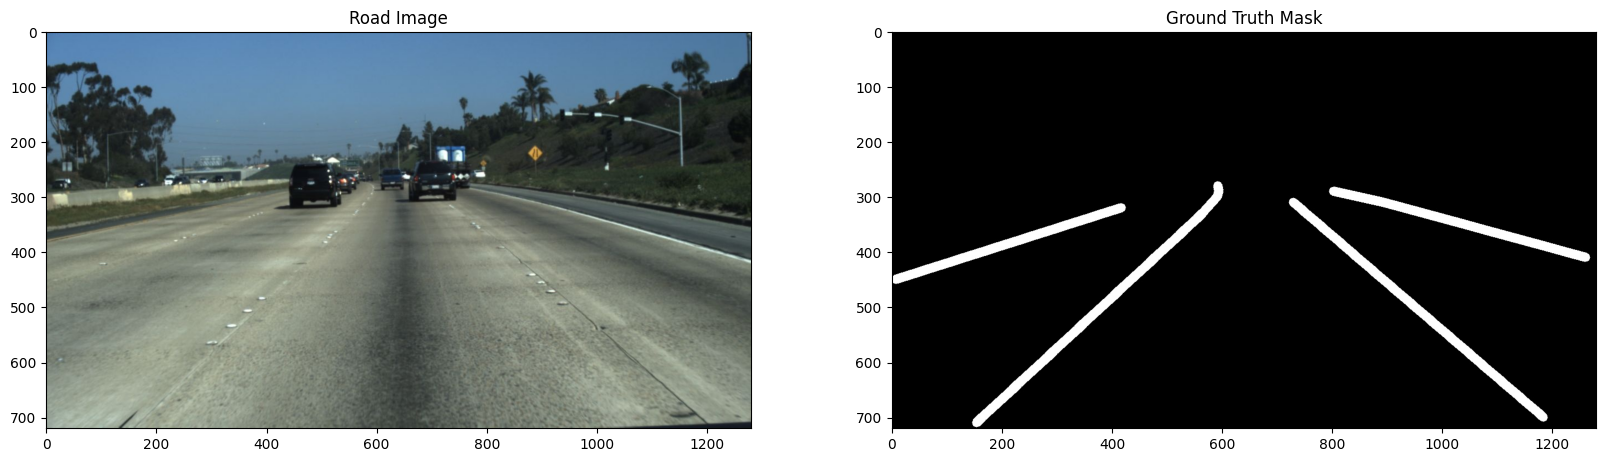

In [12]:
image_name = random.choice(os.listdir(IMAGE_FOLDER))
visualize_image(image_name)

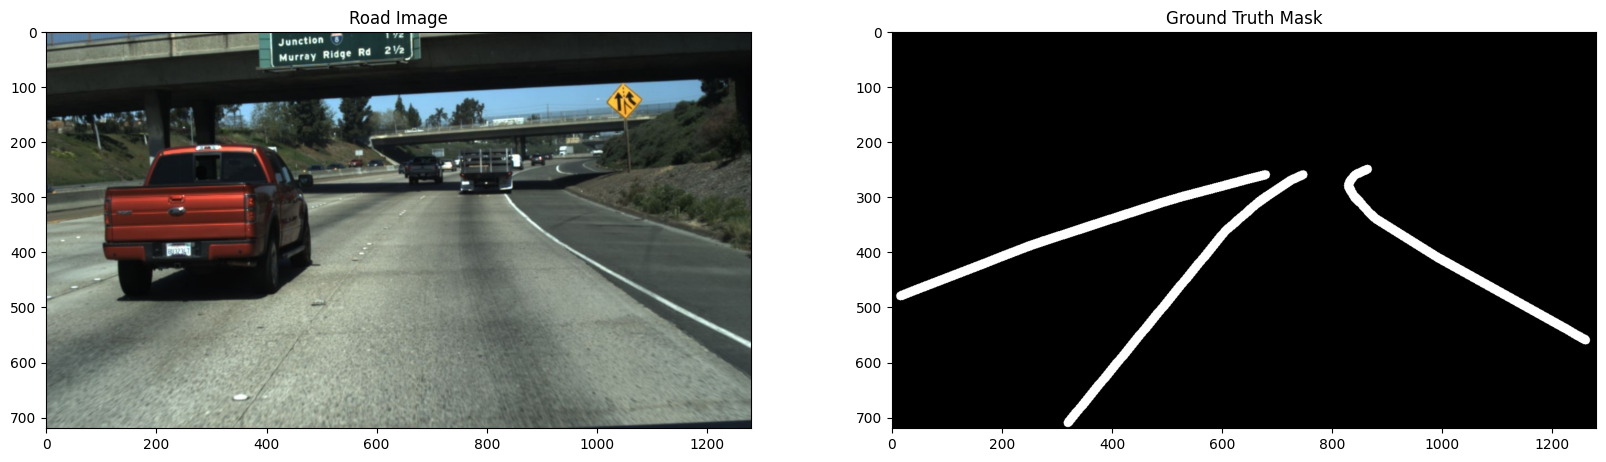

In [13]:
image_name = random.choice(os.listdir(IMAGE_FOLDER))
visualize_image(image_name)

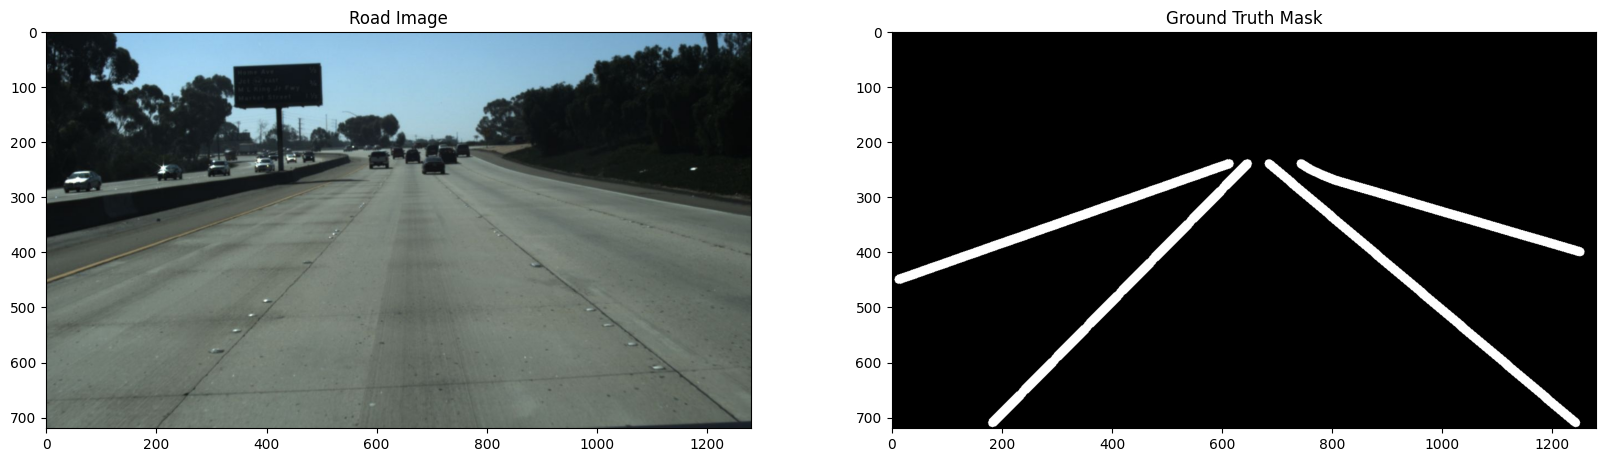

In [14]:
image_name = random.choice(os.listdir(IMAGE_FOLDER))
visualize_image(image_name)

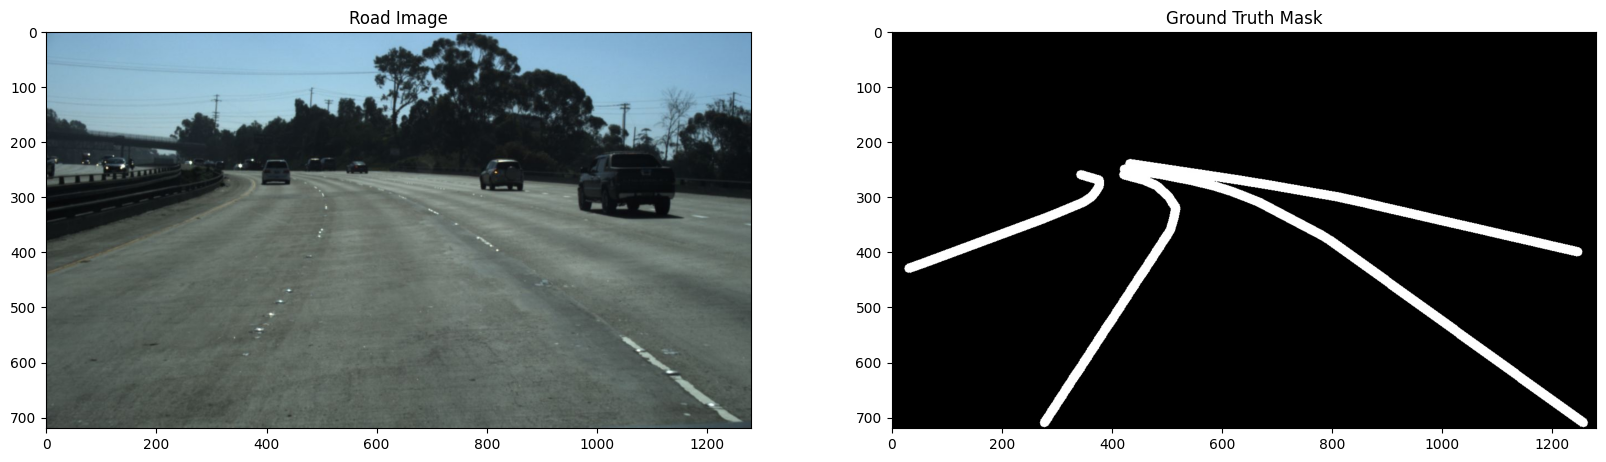

In [15]:
image_name = random.choice(os.listdir(IMAGE_FOLDER))
visualize_image(image_name)

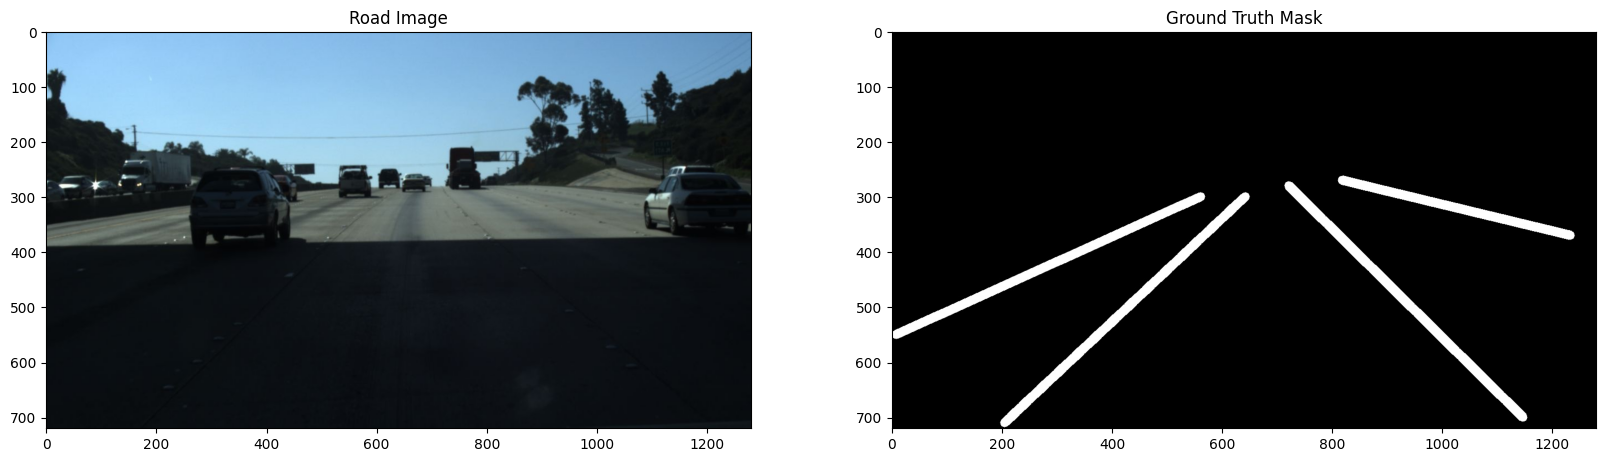

In [16]:
image_name = random.choice(os.listdir(IMAGE_FOLDER))
visualize_image(image_name)

In [17]:
train_image_folder = 'tusimple_processed/train/images'
test_image_folder = 'tusimple_processed/test/images'
train_mask_folder = 'tusimple_processed/train/masks'
test_mask_folder = 'tusimple_processed/test/masks'

In [18]:
for folder_path in [train_image_folder, test_image_folder, train_mask_folder, test_mask_folder]:
    create_directories_if_not_exist(folder_path)

Directory Created: tusimple_processed/train/images
Directory Created: tusimple_processed/test/images
Directory Created: tusimple_processed/train/masks
Directory Created: tusimple_processed/test/masks


In [19]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith('.jpg')]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith('.jpg')]

# split for train and test
train_images, test_images = train_test_split(images, test_size=0.1, random_state=42)

In [20]:
len(train_images), len(test_images)

(3263, 363)

In [21]:
# move files to the corresponding folders
for file in train_images:
    # move the image and mask
    source = os.path.join(IMAGE_FOLDER, file)
    destination = os.path.join(train_image_folder, file)
    shutil.move(source, destination)

    source = os.path.join(MASK_FOLDER, file)
    destination = os.path.join(train_mask_folder, file)
    shutil.move(source, destination)

for file in test_images:
    # move the image and mask
    source = os.path.join(IMAGE_FOLDER, file)
    destination = os.path.join(test_image_folder, file)
    shutil.move(source, destination)

    source = os.path.join(MASK_FOLDER, file)
    destination = os.path.join(test_mask_folder, file)
    shutil.move(source, destination)

In [22]:
def load_image(image_path, mask_path):
    size = [224, 224]
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image/255.0 # normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = mask/255.0 # normalize to [0, 1]

    return image, mask

def dataset_from_folder(image_folder, mask_folder):
    image_files = sorted([os.path.join(image_folder, file)
                          for file in os.listdir(image_folder) if file.endswith('.jpg')])
    mask_files = sorted([os.path.join(mask_folder, file)
                         for file in os.listdir(mask_folder) if file.endswith('.jpg')])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda image_path, mask_path: load_image(image_path, mask_path))
    return dataset

In [23]:
# load dataset from folder
train_dataset = dataset_from_folder(train_image_folder, train_mask_folder)
test_dataset = dataset_from_folder(test_image_folder, test_mask_folder)

I0000 00:00:1744750565.085685      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [24]:
# set config
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# optimize for performance improvement
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [25]:
def display_sample(image_list):
    plt.figure(figsize=(10, 10))

    titles = ['Image', 'True Mask', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

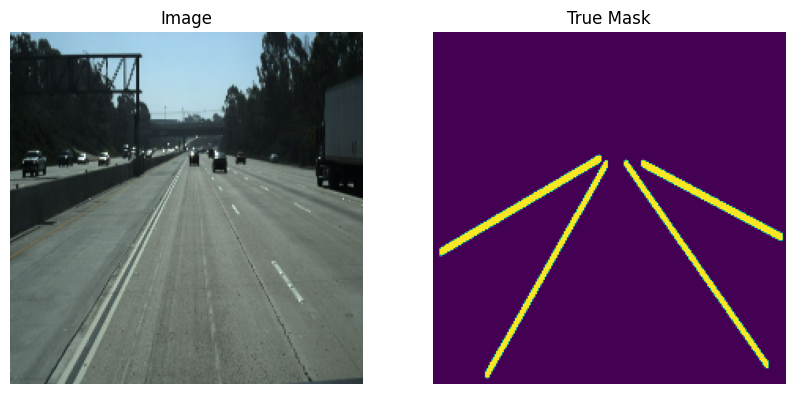

In [26]:
for image, mask in train_dataset.take(1):
    display_sample([image[0], mask[0]])

In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dropout, Activation, Add, BatchNormalization, Conv2D, Concatenate, UpSampling2D
from tensorflow.keras.models import Model
def VGG16_UNet(input_shape=(None, None, 3)):
    '''U net architecture with VGG16 encoder (down/up sampling with skip architecture)
    '''
    def Conv2DReluBatchNorm(n_filters, kernel_size, strides, inputs):
        x = Conv2D(n_filters, (1,1), strides=1, padding='same',
                   kernel_initializer='glorot_normal',
                   activation='elu')(inputs)
        x = Conv2D(n_filters, kernel_size, strides=strides, padding='same',
                   kernel_initializer='glorot_normal',
                   activation='elu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=0.25)(x, training=True) # training + test-time dropout!
        return x

    # VGG16 encoder
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Unfreeze VGG16 layers
    for layer in vgg16.layers:
        layer.trainable = True

    # Encoder layers
    inputs = vgg16.input
    layer1 = vgg16.get_layer('block1_conv2').output
    layer2 = vgg16.get_layer('block2_conv2').output
    layer3 = vgg16.get_layer('block3_conv3').output
    layer4 = vgg16.get_layer('block4_conv3').output
    layer5 = vgg16.get_layer('block5_conv3').output

    # Decoder layers
    merge6 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer5), layer4])
    layer6 = Conv2DReluBatchNorm(512, (3, 3), (1,1), merge6)

    merge7 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer6), layer3])
    layer7 = Conv2DReluBatchNorm(256, (3, 3), (1,1), merge7)

    merge8 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer7), layer2])
    layer8 = Conv2DReluBatchNorm(128, (3, 3), (1,1), merge8)

    merge9 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer8), layer1])
    layer9 = Conv2DReluBatchNorm(64, (3, 3), (1,1), merge9)

    output = Conv2D(1, (1, 1), strides=(1,1), activation='sigmoid', name='output')(layer9)

    return Model(inputs=inputs, outputs=output)

model = VGG16_UNet(input_shape=(224, 224, 3))  # Adjust input shape as needed


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [28]:
import tensorflow
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred):
    y_true_f=K.flatten(y_true)
    mu     = y_pred[:,:,:,0]
    y_pred_f=K.flatten(mu)
    intersection=K.sum(y_true_f*y_pred_f)
    smooth=1.0
    return (2*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

def recall_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_true_f) + K.epsilon()))

def precision_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_pred_f) + K.epsilon()))

def accuracy(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    
    # True positives
    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    
    # True negatives
    true_negatives = K.sum(K.round(K.clip((1 - y_true_f) * (1 - y_pred_f), 0, 1)))
    
    # Total pixels
    total_pixels = K.cast(tensorflow.size(y_true_f), K.floatx())
    
    # Accuracy
    accuracy_value = (true_positives + true_negatives) / total_pixels
    
    return accuracy_value

In [29]:
# compile the model
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient, precision_smooth, recall_smooth, accuracy])
print('Number of parameters:', model.count_params())

Number of parameters: 18636289


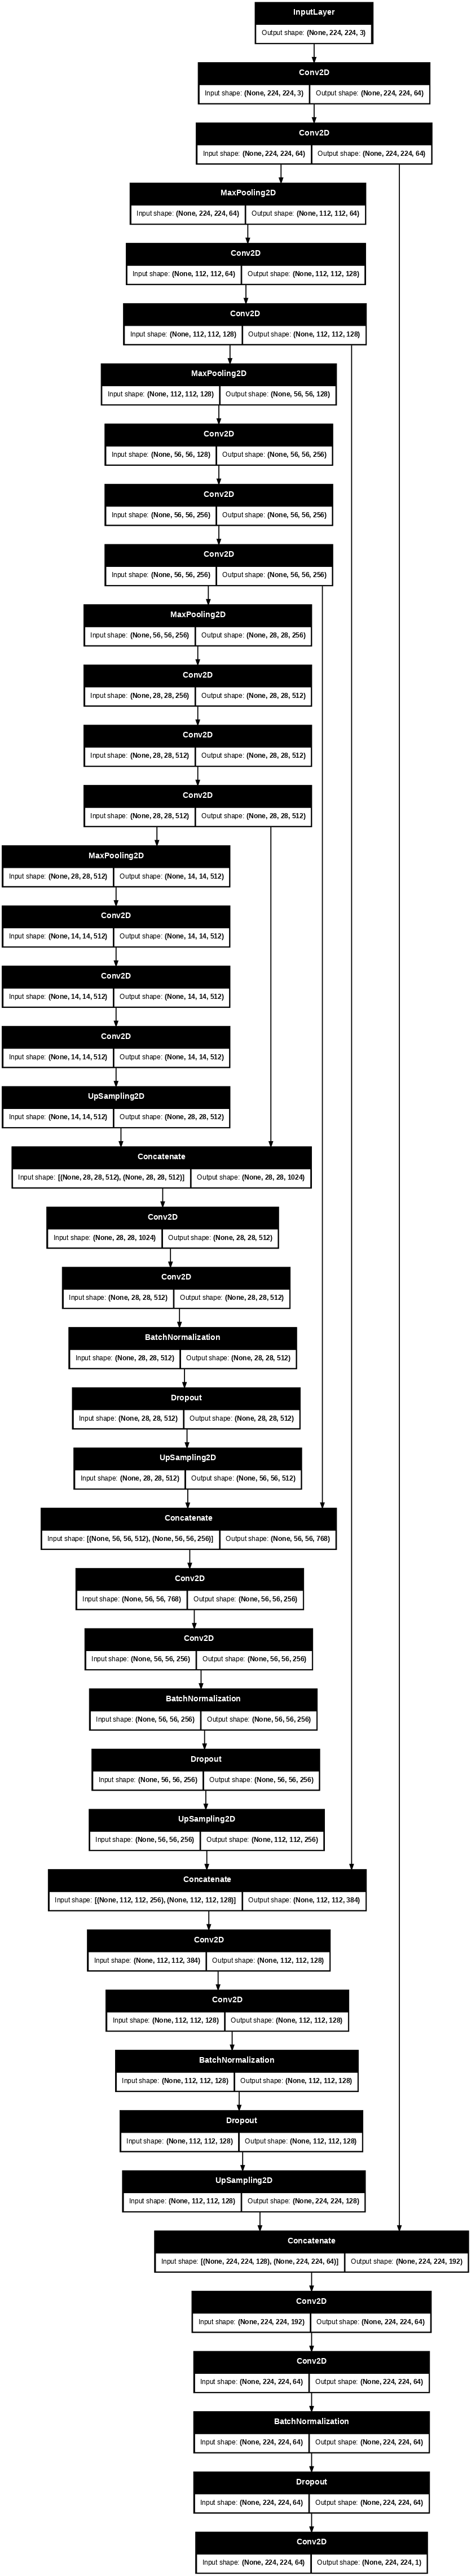

In [30]:
# plot the model
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, dpi=64)

In [31]:
# create mask from prediction
def create_mask(pred_mask):
    # round to closest
    pred_mask = tf.math.round(pred_mask)
    return pred_mask

def show_predictions(dataset=None, num=1):
    if dataset:
        for images, masks in dataset.take(num):
            pred_mask = model.predict(images)
            pred_mask = create_mask(pred_mask[0])
            display_sample([images[0], masks[0], pred_mask])

I0000 00:00:1744750576.628791      97 service.cc:148] XLA service 0x7a69a8005e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744750576.629515      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744750576.800857      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


I0000 00:00:1744750591.841002      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


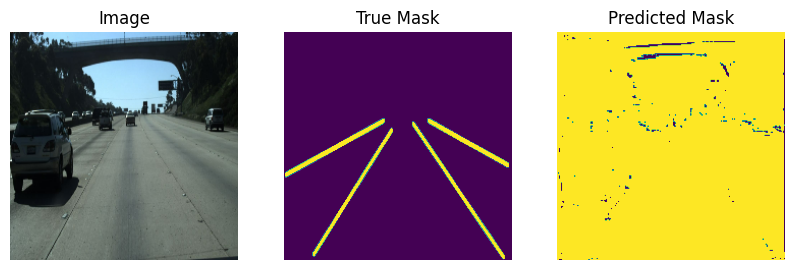

In [32]:
show_predictions(train_dataset, 1)

In [33]:
# callbacks and logs
from tensorflow.keras import callbacks
import datetime

class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(test_dataset, 1)
        print(f'Sample Prediction after epoch {epoch}\n')

logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq=-1),
    callbacks.EarlyStopping(patience=5, verbose=1),
    callbacks.ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True)
]

In [34]:
EPOCHS = 10
steps_per_epoch = len(os.listdir(train_image_folder)) // BATCH_SIZE
validation_steps = len(os.listdir(test_image_folder)) // BATCH_SIZE

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step/step - accuracy: 0.8395 - dice_coefficient: 0.3214 - loss: 0.6786 - precision_smooth: 0.2148 - recall_smooth: 0.761


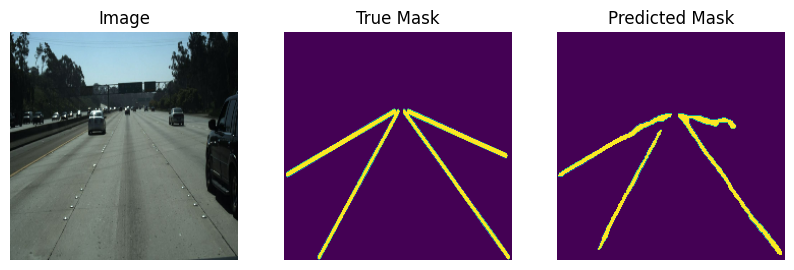

Sample Prediction after epoch 0


Epoch 1: val_loss improved from inf to 0.36258, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 94s 533ms/step - accuracy: 0.8402 - dice_coefficient: 0.3227 - loss: 0.6773 - precision_smooth: 0.2160 - recall_smooth: 0.7619 - val_accuracy: 0.9714 - val_dice_coefficient: 0.6374 - val_loss: 0.3626 - val_precision_smooth: 0.6868 - val_recall_smooth: 0.5958
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9691 - dice_coefficient: 0.6643 - loss: 0.3357 - precision_smooth: 0.5905 - recall_smooth: 0.7624

E0000 00:00:1744750735.845301      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744750736.094708      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


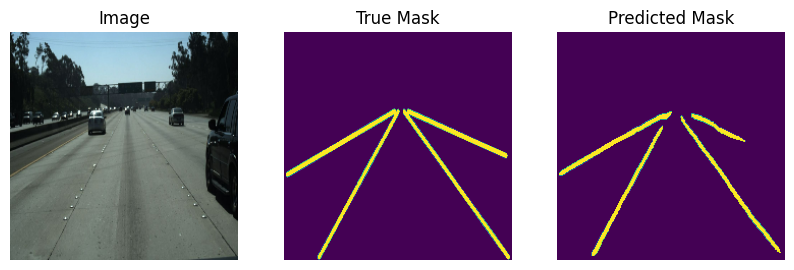

Sample Prediction after epoch 1


Epoch 2: val_loss did not improve from 0.36258
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 540ms/step - accuracy: 0.9691 - dice_coefficient: 0.6646 - loss: 0.3354 - precision_smooth: 0.5909 - recall_smooth: 0.7624 - val_accuracy: 0.9690 - val_dice_coefficient: 0.6084 - val_loss: 0.3916 - val_precision_smooth: 0.7362 - val_recall_smooth: 0.5183
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step/step - accuracy: 0.9763 - dice_coefficient: 0.7332 - loss: 0.2668 - precision_smooth: 0.6934 - recall_smooth: 0.778


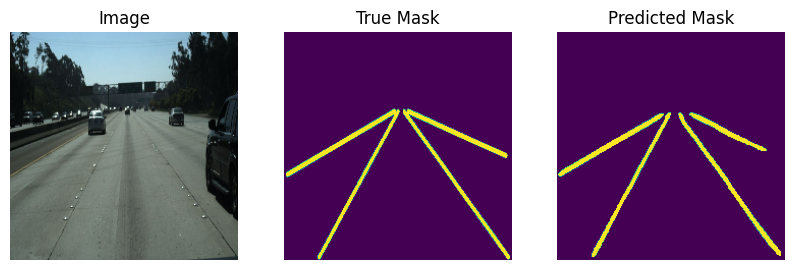

Sample Prediction after epoch 2


Epoch 3: val_loss improved from 0.36258 to 0.24756, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 504ms/step - accuracy: 0.9763 - dice_coefficient: 0.7332 - loss: 0.2668 - precision_smooth: 0.6935 - recall_smooth: 0.7785 - val_accuracy: 0.9787 - val_dice_coefficient: 0.7524 - val_loss: 0.2476 - val_precision_smooth: 0.7405 - val_recall_smooth: 0.7658
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step/step - accuracy: 0.9780 - dice_coefficient: 0.7540 - loss: 0.2460 - precision_smooth: 0.7177 - recall_smooth: 0.794


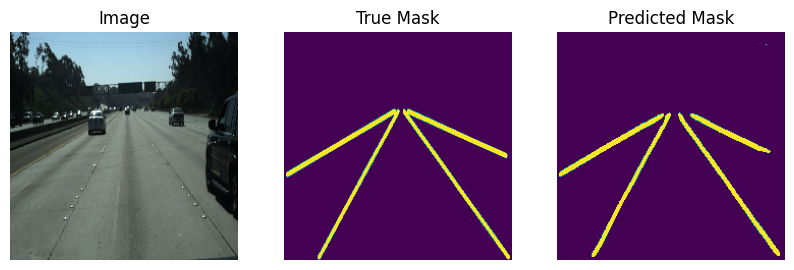

Sample Prediction after epoch 3


Epoch 4: val_loss did not improve from 0.24756
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 483ms/step - accuracy: 0.9780 - dice_coefficient: 0.7540 - loss: 0.2460 - precision_smooth: 0.7177 - recall_smooth: 0.7944 - val_accuracy: 0.9711 - val_dice_coefficient: 0.6677 - val_loss: 0.3323 - val_precision_smooth: 0.7150 - val_recall_smooth: 0.6263
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step/step - accuracy: 0.9792 - dice_coefficient: 0.7657 - loss: 0.2343 - precision_smooth: 0.7343 - recall_smooth: 0.800


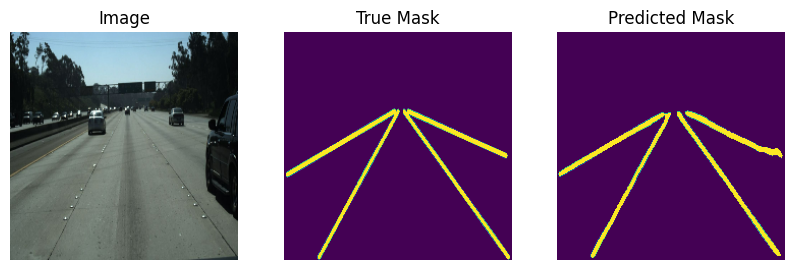

Sample Prediction after epoch 4


Epoch 5: val_loss improved from 0.24756 to 0.23731, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 505ms/step - accuracy: 0.9792 - dice_coefficient: 0.7657 - loss: 0.2343 - precision_smooth: 0.7343 - recall_smooth: 0.8002 - val_accuracy: 0.9790 - val_dice_coefficient: 0.7627 - val_loss: 0.2373 - val_precision_smooth: 0.7279 - val_recall_smooth: 0.8016
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step/step - accuracy: 0.9795 - dice_coefficient: 0.7700 - loss: 0.2300 - precision_smooth: 0.7377 - recall_smooth: 0.805


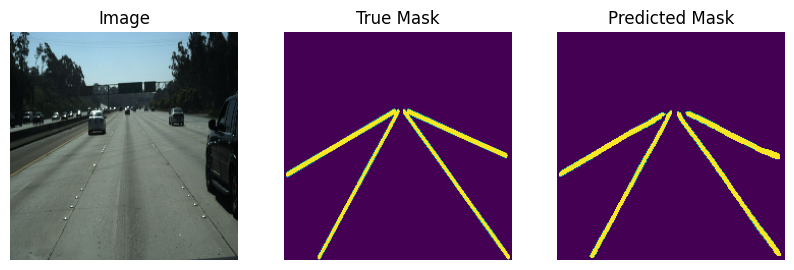

Sample Prediction after epoch 5


Epoch 6: val_loss did not improve from 0.23731
101/101 ━━━━━━━━━━━━━━━━━━━━ 48s 479ms/step - accuracy: 0.9795 - dice_coefficient: 0.7700 - loss: 0.2300 - precision_smooth: 0.7377 - recall_smooth: 0.8056 - val_accuracy: 0.9689 - val_dice_coefficient: 0.6703 - val_loss: 0.3297 - val_precision_smooth: 0.6588 - val_recall_smooth: 0.6823
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step/step - accuracy: 0.9799 - dice_coefficient: 0.7752 - loss: 0.2248 - precision_smooth: 0.7441 - recall_smooth: 0.809


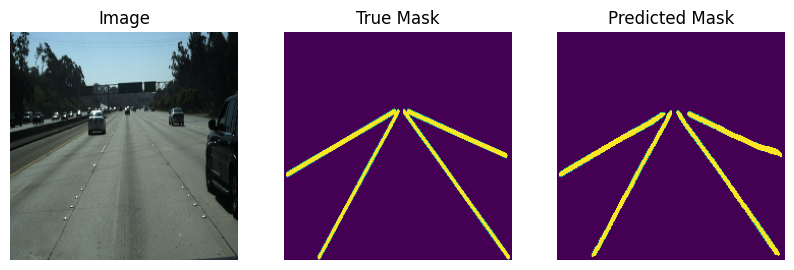

Sample Prediction after epoch 6


Epoch 7: val_loss improved from 0.23731 to 0.23387, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 505ms/step - accuracy: 0.9799 - dice_coefficient: 0.7752 - loss: 0.2248 - precision_smooth: 0.7441 - recall_smooth: 0.8091 - val_accuracy: 0.9789 - val_dice_coefficient: 0.7661 - val_loss: 0.2339 - val_precision_smooth: 0.7205 - val_recall_smooth: 0.8185
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step/step - accuracy: 0.9800 - dice_coefficient: 0.7760 - loss: 0.2240 - precision_smooth: 0.7446 - recall_smooth: 0.810


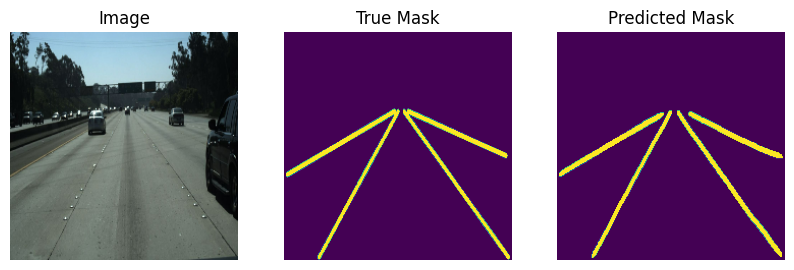

Sample Prediction after epoch 7


Epoch 8: val_loss did not improve from 0.23387
101/101 ━━━━━━━━━━━━━━━━━━━━ 48s 479ms/step - accuracy: 0.9800 - dice_coefficient: 0.7760 - loss: 0.2240 - precision_smooth: 0.7446 - recall_smooth: 0.8106 - val_accuracy: 0.9688 - val_dice_coefficient: 0.6704 - val_loss: 0.3296 - val_precision_smooth: 0.6579 - val_recall_smooth: 0.6835
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step/step - accuracy: 0.9810 - dice_coefficient: 0.7845 - loss: 0.2155 - precision_smooth: 0.7567 - recall_smooth: 0.814


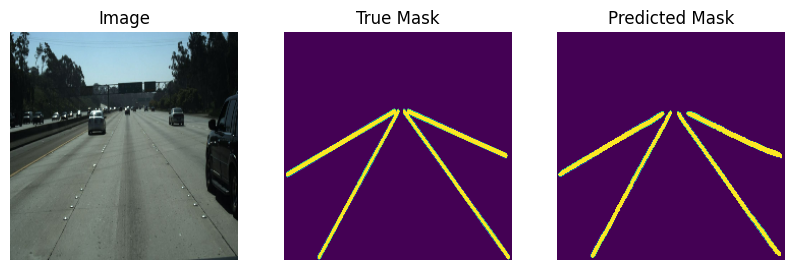

Sample Prediction after epoch 8


Epoch 9: val_loss improved from 0.23387 to 0.23007, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 504ms/step - accuracy: 0.9810 - dice_coefficient: 0.7845 - loss: 0.2155 - precision_smooth: 0.7567 - recall_smooth: 0.8146 - val_accuracy: 0.9797 - val_dice_coefficient: 0.7699 - val_loss: 0.2301 - val_precision_smooth: 0.7370 - val_recall_smooth: 0.8061
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step/step - accuracy: 0.9811 - dice_coefficient: 0.7864 - loss: 0.2136 - precision_smooth: 0.7580 - recall_smooth: 0.817


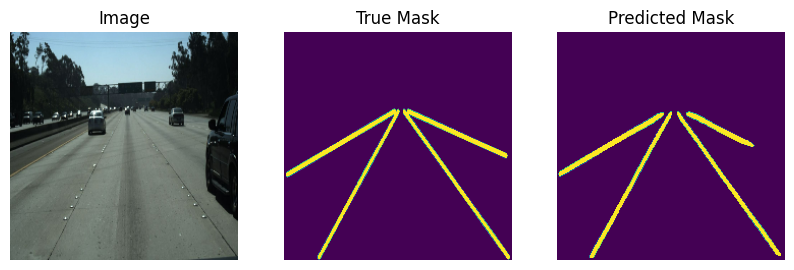

Sample Prediction after epoch 9


Epoch 10: val_loss did not improve from 0.23007
101/101 ━━━━━━━━━━━━━━━━━━━━ 48s 479ms/step - accuracy: 0.9811 - dice_coefficient: 0.7864 - loss: 0.2136 - precision_smooth: 0.7580 - recall_smooth: 0.8173 - val_accuracy: 0.9689 - val_dice_coefficient: 0.6725 - val_loss: 0.3275 - val_precision_smooth: 0.6575 - val_recall_smooth: 0.6881


In [35]:
# train the model
history = model.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

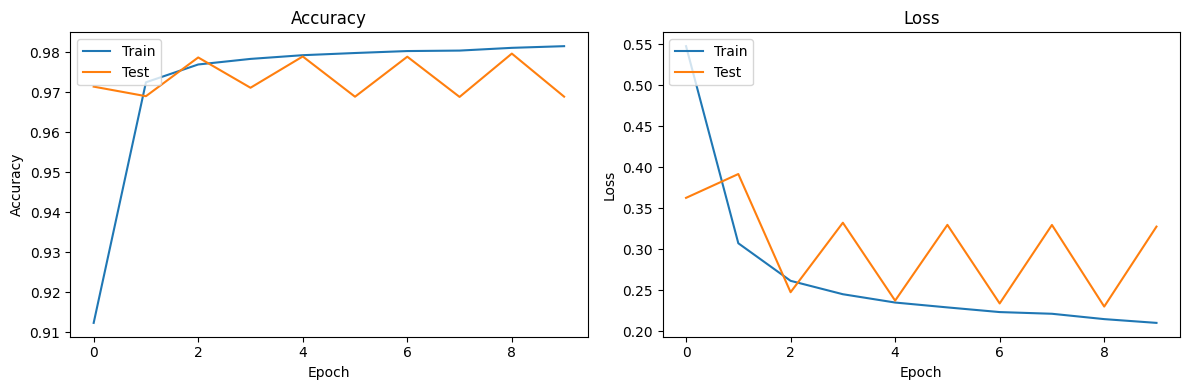

In [36]:
# plot train and val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# plot train and val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
best_model = tf.keras.models.load_model('best_model.keras', 
                                        custom_objects={'dice_loss': dice_loss, 
                                                        'dice_coefficient': dice_coefficient,
                                                        'precision_smooth': precision_smooth,
                                                        'recall_smooth': recall_smooth,
                                                        'accuracy': accuracy
                                                       })
# best_model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


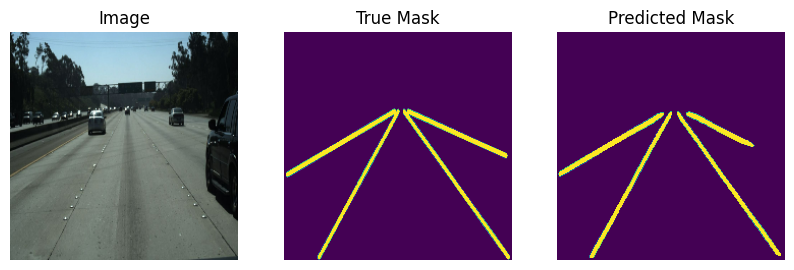

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


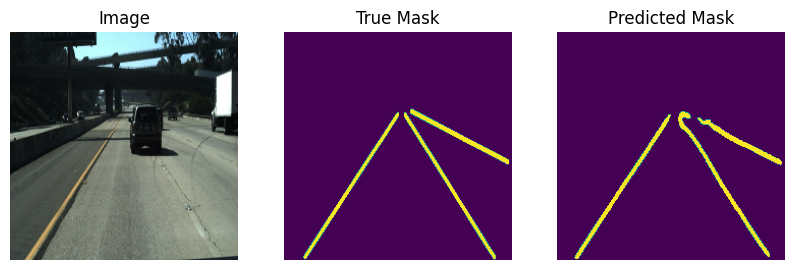

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


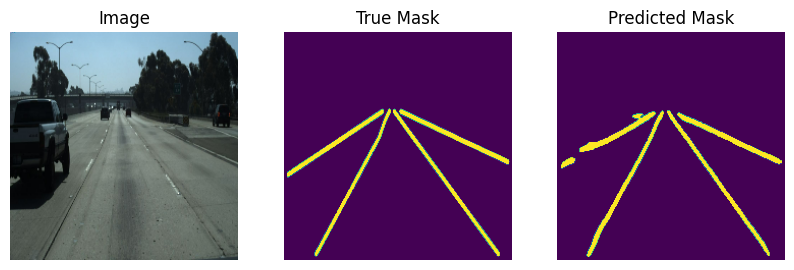

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


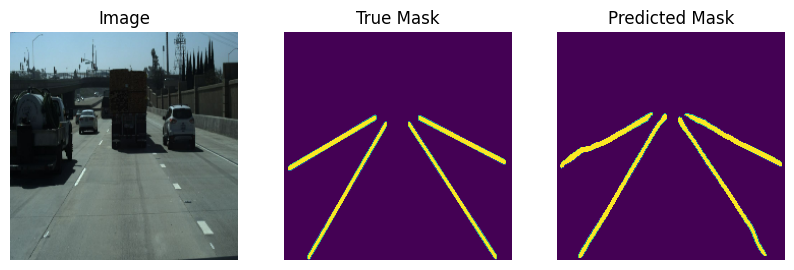

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


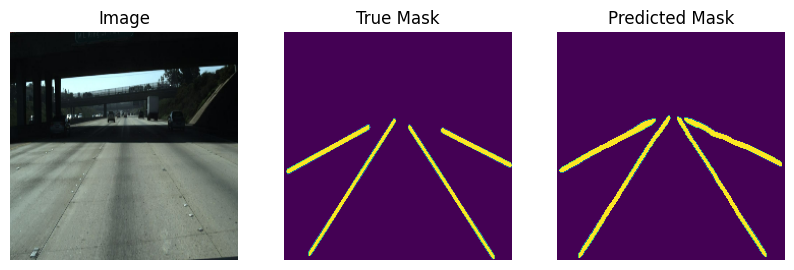

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


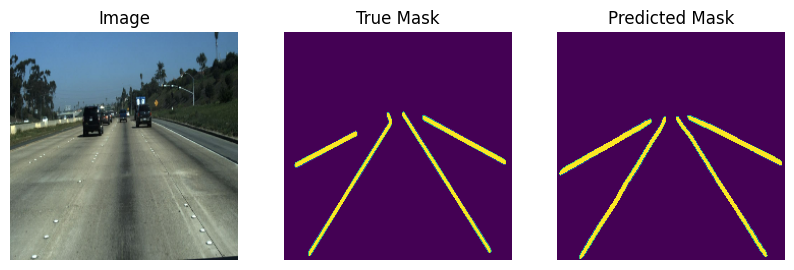

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


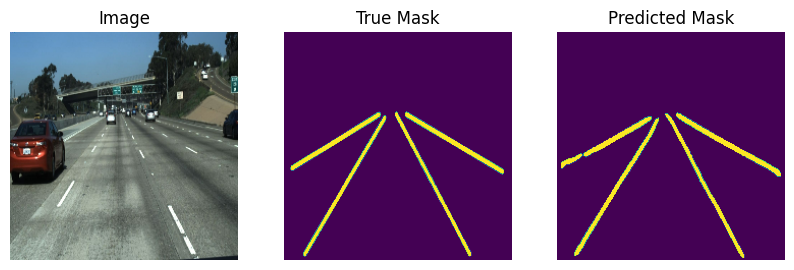

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


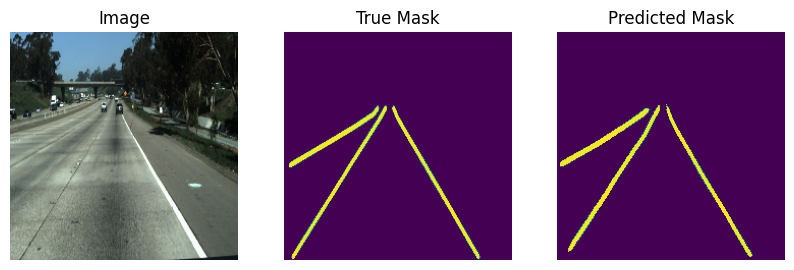

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


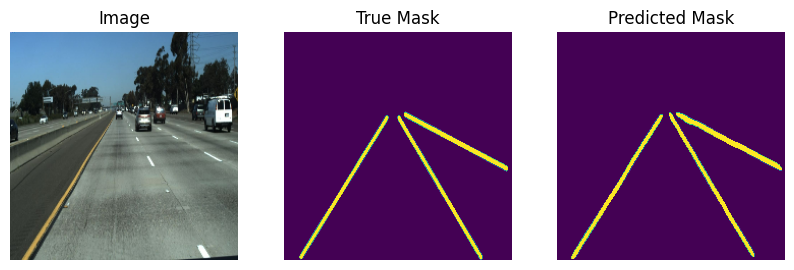

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


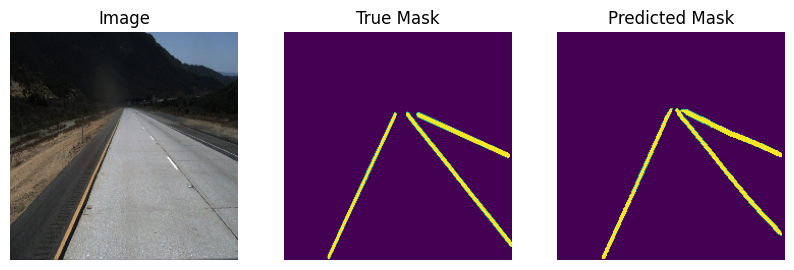

In [38]:
show_predictions(test_dataset, 10)

In [39]:
def load_test_image(image_path):
    size = [224, 224]
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image/255.0 # normalize to [0, 1]
    return image

def display_test_sample(image_list):
    plt.figure(figsize=(10, 10))

    titles = ['Image', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


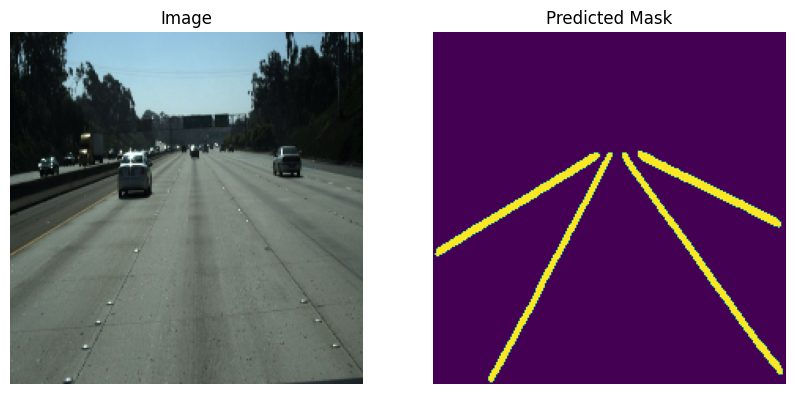

In [40]:
image_path = "/kaggle/input/tusimple/TUSimple/train_set/clips/0313-1/10000/20.jpg"
image = load_test_image(image_path)
test_image = tf.expand_dims(image, axis=0)
pred_mask = best_model.predict(test_image)
pred_mask = create_mask(pred_mask[0])
display_test_sample([image, pred_mask])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


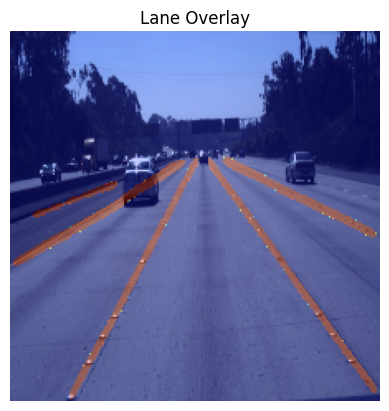

In [46]:
import cv2
import matplotlib.pyplot as plt

def overlay_mask(image, mask):
    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))
    mask_colored = cv2.applyColorMap((mask_resized * 255).astype('uint8'), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(image, 0.8, mask_colored, 0.5, 0)
    return blended

# Example
image = cv2.imread('/kaggle/input/tusimple/TUSimple/train_set/clips/0313-1/10000/20.jpg')
image = cv2.resize(image, (224, 224))

input_img = np.expand_dims(image / 255.0, axis=0)
predicted_mask = model.predict(input_img)[0, :, :, 0]

overlay = overlay_mask(image, predicted_mask)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Lane Overlay")
plt.show()
